# Machine Learning Practical: Coursework 2
## Experiment 2/3

**Due date: 16:00 Thursday 24th November 2016**

# Georgios Pligoropoulos - s1687568

In [1]:
import sys
mlpdir = '/home/student/Dropbox/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical'
sys.path.append(mlpdir)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import logging

#%matplotlib notebook
%matplotlib inline

In [3]:
from mlp.data_providers import MNISTDataProvider

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, MaxPoolingLayer, DropoutLayer

from mlp.errors import CrossEntropySoftmaxError

from mlp.models import MultipleLayerModel

from mlp.initialisers import ConstantInit, GlorotUniformInit

from mlp.optimisers import Optimiser

from mlp.learning_rules import GradientDescentLearningRule, MomentumLearningRule, \
    AdaGradLearningRule, RmsPropLearningRule
    
from mlp.schedulers import AnnealedDropoutScheduler, MomentumCoefficientScheduler, ConstantLearningRateScheduler,\
    ReciprocalLearningRateScheduler, ExponentialLearningRateScheduler

In [4]:
def trainModel(model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers=[]):
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors, schedulers = schedulers)

    # Run the optimiser for some number of epochs (full passes through the training set)
    # printing statistics every epoch
    stats, keys, runTime = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
    #stats = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    return stats, keys, runTime

In [5]:
def plotStats(stats, keys, stats_interval):
    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    
    return fig_1, ax_1, fig_2, ax_2

In [6]:
def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers=[]):
    
    stats, keys, runTime = trainModel(model, error, learning_rule, train_data, valid_data,
                                       num_epochs, stats_interval, schedulers)

    fig_1, ax_1, fig_2, ax_2 = plotStats(stats=stats, keys=keys)
    
    return stats, keys, fig_1, ax_1, fig_2, ax_2, runTime

In [7]:
def getFinalValues(statistics):
    lastStats = statistics[-1]
    return {
        "Final Training Error": lastStats[0],
        "Final Training Accuracy": lastStats[1],
        "Final Testing Error": lastStats[2],
        "Final Testing Accuracy": lastStats[3],
    }

In [8]:
seed = 16011984
rng = np.random.RandomState(seed)

Note: When in our explanations refer to **accuracy** we mean the final validation accuracy and when we refer to **performance** we mean how fast we reached the optimal accuracy for the current experiment

# Grand Experiment 2: Annealed Dropout with Maxout

Here first we will explore how Dropout works together with Maxout combining the experiments of lab6 as it is suggested that they generally produce good enough results together.

Afterwards we will explore the system using the RMSprop implementation from coursework1 to boost the performance of our implementation.

The next step is to optimize dropout by using annealed dropout methodology. So instead of using a fixed probability we are going to change it dynamically. We are going to start from a low inclusive-probabily (probability of input being included in output in dropout layer) and we are going to gradually increase the probability as the epochs go by. We are going to stop when probability reaches 100%.

In [9]:
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

In [10]:
# Seed a random number generator

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
trainData = MNISTDataProvider('train', batch_size=50, rng=rng)
validData = MNISTDataProvider('valid', batch_size=50, rng=rng)

# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError() #this does not contain any immutable data that's why it can be set only once

In [11]:
statsInterval = 5

Note that we are going to use an architecture that is in consice with the conclusions from Grand Experiment 1.
We are going to use the two layer model which is much faster in terms of performance and it will allow us to execute more experiments

In [12]:
#input_dim, output_dim, hidden_dim_layer1, hidden_dim_layer2 = 784, 10, 140, 100
input_dim, output_dim, hidden_dim = 784, 10, 140

In [1]:
figcount = 0

## Maxout

Epoch 0:
  error(train)=2.45e+00, acc(train)=1.05e-01, error(valid)=2.44e+00, acc(valid)=1.11e-01, params_penalty=0.00e+00
Epoch 5: 5.12s to complete
  error(train)=2.88e-02, acc(train)=9.92e-01, error(valid)=7.67e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 10: 6.85s to complete
  error(train)=4.90e-03, acc(train)=1.00e+00, error(valid)=6.56e-02, acc(valid)=9.82e-01, params_penalty=0.00e+00
Epoch 15: 5.93s to complete
  error(train)=2.13e-03, acc(train)=1.00e+00, error(valid)=6.74e-02, acc(valid)=9.83e-01, params_penalty=0.00e+00
Epoch 20: 6.19s to complete
  error(train)=1.35e-03, acc(train)=1.00e+00, error(valid)=6.97e-02, acc(valid)=9.83e-01, params_penalty=0.00e+00
Epoch 25: 5.55s to complete
  error(train)=9.93e-04, acc(train)=1.00e+00, error(valid)=7.15e-02, acc(valid)=9.83e-01, params_penalty=0.00e+00
Epoch 30: 5.51s to complete
  error(train)=7.78e-04, acc(train)=1.00e+00, error(valid)=7.31e-02, acc(valid)=9.83e-01, params_penalty=0.00e+00
Epoch 35: 5.53s to complet

runtime: 389.950199127


{'Final Testing Accuracy': 0.98369999999999902,
 'Final Testing Error': 0.078179863515805789,
 'Final Training Accuracy': 1.0,
 'Final Training Error': 0.00032944897215494046}

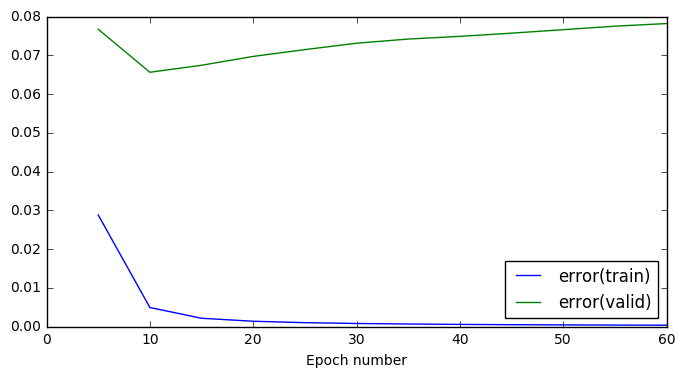

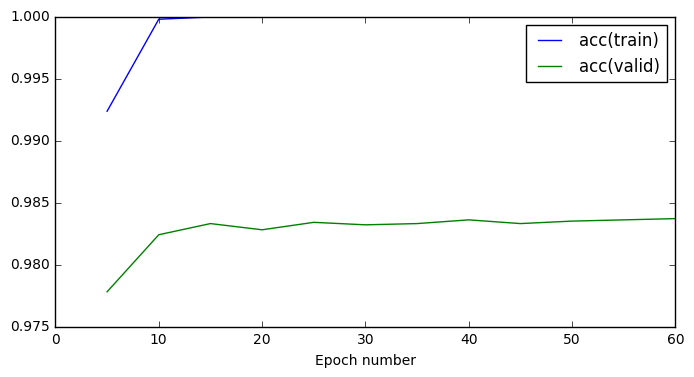

In [13]:
numEpochs = 60

# Size of pools to take maximum over
pool_size = 4

# Use a momentum learning rule - you could use an adaptive learning rule
# implemented for the coursework here instead
learningRule = MomentumLearningRule(0.02) #let's use the recommended defaults instead

# Create three affine layer model interleaved with max-pooling layers
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim * pool_size, weights_init, biases_init), 
    MaxPoolingLayer(pool_size),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

stats, keys, runTime = trainModel(model=model, error=error,learning_rule=learningRule, train_data=trainData,
                                   valid_data=validData,num_epochs = numEpochs, stats_interval=statsInterval,
                                   schedulers = [
        #ConstantLearningRateScheduler(learning_rate) #this actually does nothing so it's useless to include it
    ]
)

fig_1, ax_1, fig_2, ax_2 = plotStats(stats=stats, keys=keys, stats_interval=statsInterval)
figcount += 1
fig_1.savefig('experiment2_%02d_maxout_fig1.svg' % figcount)
fig_2.savefig('experiment2_%02d_maxout_fig2.svg' % figcount)

print "figcount: " + str(figcount)
print "runtime: " + str(runTime)

getFinalValues(stats)

Note that the learning here is 1e-3 while in the one used in the lab was 2e-2

Even with smaller learning rate the momentum drives the learning properly to achieve an accuracy of ~98% within 60 epochs

If we increase the learning rate we are going to easily overfit. That's why we need to bring dropout to the game.

## Maxout  and Dropout with momentum learning rule

Epoch 0:
  error(train)=2.37e+00, acc(train)=1.07e-01, error(valid)=2.37e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 7.01s to complete
  error(train)=9.08e-02, acc(train)=9.72e-01, error(valid)=1.13e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 10: 7.65s to complete
  error(train)=5.44e-02, acc(train)=9.83e-01, error(valid)=1.03e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 15: 7.11s to complete
  error(train)=4.29e-02, acc(train)=9.86e-01, error(valid)=9.79e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 20: 6.65s to complete
  error(train)=3.21e-02, acc(train)=9.90e-01, error(valid)=9.41e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 25: 7.09s to complete
  error(train)=3.12e-02, acc(train)=9.89e-01, error(valid)=9.31e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 30: 6.71s to complete
  error(train)=2.52e-02, acc(train)=9.92e-01, error(valid)=9.60e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 35: 6.79s to complet

runtime: 775.867121935


{'Final Testing Accuracy': 0.97809999999999919,
 'Final Testing Error': 0.10682848345968722,
 'Final Training Accuracy': 0.99670000000000214,
 'Final Training Error': 0.01097044801313264}

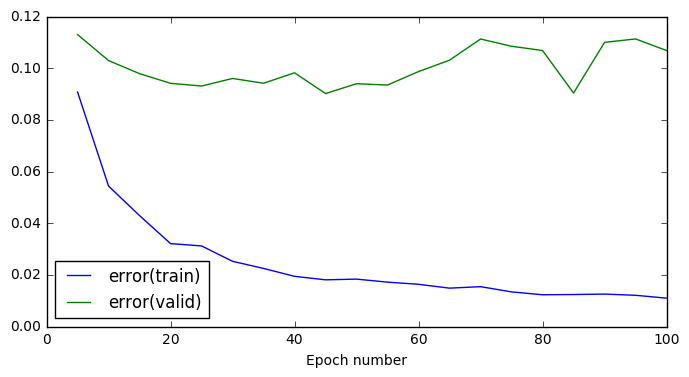

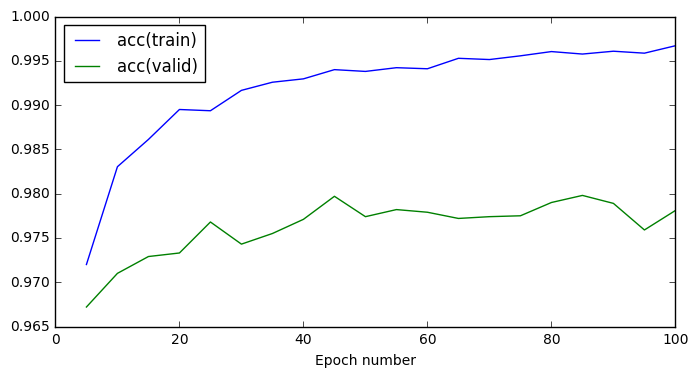

In [14]:
numEpochs = 100

# Size of pools to take maximum over
pool_size = 4

# Probability of input being included in output in dropout layer
input_incl_prob = 0.9 #different for input layer
hidden_incl_prob = 0.6 #than the rest of the layers

# Use a momentum learning rule
learningRule = MomentumLearningRule(learning_rate=0.02) #and leave mom coefficient to the default 0.9

# Create three affine layer model interleaved with max-pooling layers
model = MultipleLayerModel([
    #layer
    DropoutLayer(rng, input_incl_prob),
    AffineLayer(input_dim, hidden_dim * pool_size, weights_init, biases_init), 
    MaxPoolingLayer(pool_size),
        
    #layer
    DropoutLayer(rng, hidden_incl_prob),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

stats, keys, runTime = trainModel(model=model, error=error,learning_rule=learningRule, train_data=trainData,
                                   valid_data=validData,num_epochs = numEpochs, stats_interval=statsInterval,
                                   schedulers = [
        #ConstantLearningRateScheduler(learning_rate) #this actually does nothing so it's useless to include it
    ]
)

fig_1, ax_1, fig_2, ax_2 = plotStats(stats=stats, keys=keys, stats_interval=statsInterval)
figcount += 1
fig_1.savefig('experiment2_%02d_maxout_dropout_fig1.svg' % figcount)
fig_2.savefig('experiment2_%02d_maxout_dropout_fig2.svg' % figcount)

print "figcount: " + str(figcount)
print "runtime: " + str(runTime)

getFinalValues(stats)

With a much higher learning rate dropout managed to achieve good regularization and stabilized the validation error instead of leaving it to increase. However we didn't manage to achieve a high validation accuracy as before

Next we are going to remove the momentum learning rule and use the RMSprop learning rule instead which proved to be better overall in coursework1. Meaning that this adaptive learning rate was flexible enough to allow even small learning rates to be adapted quickly and efficiently

## Maxout (pool size = 4)  and Dropout with RMSprop

Epoch 0:
  error(train)=2.35e+00, acc(train)=1.08e-01, error(valid)=2.35e+00, acc(valid)=1.05e-01, params_penalty=0.00e+00
Epoch 5: 10.28s to complete
  error(train)=1.96e-01, acc(train)=9.44e-01, error(valid)=1.88e-01, acc(valid)=9.47e-01, params_penalty=0.00e+00
Epoch 10: 11.79s to complete
  error(train)=1.38e-01, acc(train)=9.60e-01, error(valid)=1.41e-01, acc(valid)=9.61e-01, params_penalty=0.00e+00
Epoch 15: 13.59s to complete
  error(train)=1.11e-01, acc(train)=9.67e-01, error(valid)=1.19e-01, acc(valid)=9.66e-01, params_penalty=0.00e+00
Epoch 20: 12.02s to complete
  error(train)=9.71e-02, acc(train)=9.72e-01, error(valid)=1.12e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 25: 11.97s to complete
  error(train)=8.56e-02, acc(train)=9.74e-01, error(valid)=1.09e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 30: 12.14s to complete
  error(train)=7.87e-02, acc(train)=9.77e-01, error(valid)=1.04e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 35: 11.82s to 

runtime: 1281.10038996


{'Final Testing Accuracy': 0.97619999999999896,
 'Final Testing Error': 0.092352949149768368,
 'Final Training Accuracy': 0.98880000000000567,
 'Final Training Error': 0.039424900776501695}

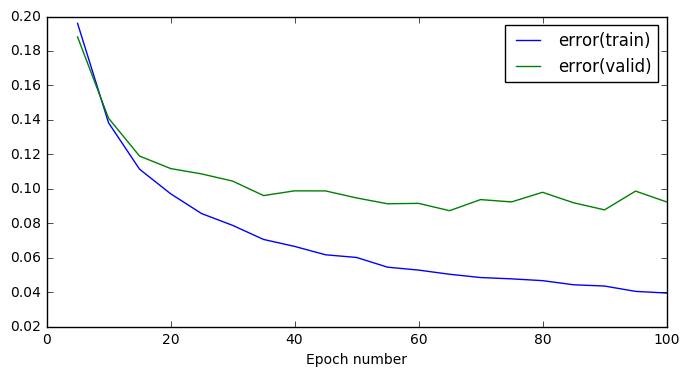

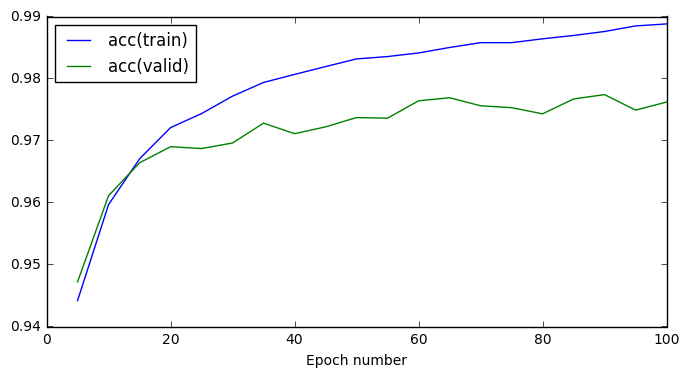

In [15]:
learningRate = 1e-4
beta = 0.9
learningRule = RmsPropLearningRule(learning_rate=learningRate, beta=beta)

numEpochs = 100

# Size of pools to take maximum over
pool_size = 4

# Probability of input being included in output in dropout layer
input_incl_prob = 0.9 #different for input layer
hidden_incl_prob = 0.6 #than the rest of the layers

#####################

# Create three affine layer model interleaved with max-pooling layers
model = MultipleLayerModel([
    #layer
    DropoutLayer(rng, input_incl_prob),
    AffineLayer(input_dim, hidden_dim * pool_size, weights_init, biases_init), 
    MaxPoolingLayer(pool_size),
        
    #layer
    DropoutLayer(rng, hidden_incl_prob),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

stats, keys, runTime = trainModel(model=model, error=error,learning_rule=learningRule, train_data=trainData,
                                   valid_data=validData,num_epochs = numEpochs, stats_interval=statsInterval,
                                   schedulers = [
        #ConstantLearningRateScheduler(learning_rate) #this actually does nothing so it's useless to include it
    ]
)

fig_1, ax_1, fig_2, ax_2 = plotStats(stats=stats, keys=keys, stats_interval=statsInterval)
figcount += 1
fig_1.savefig('experiment2_%02d_maxout_dropout_rmsProp_fig1.svg' % figcount)
fig_2.savefig('experiment2_%02d_maxout_dropout_rmsProp_fig2.svg' % figcount)

print "figcount: " + str(figcount)
print "runtime: " + str(runTime)

getFinalValues(stats)

This experiment was quite slow and took one third of an hour to execute. This will not be very helpful to try different parameters.

We are going to repeat it by trying a maxout pool size of 2

## Maxout (pool size = 2)  and Dropout with RMSprop

Epoch 0:
  error(train)=2.39e+00, acc(train)=9.99e-02, error(valid)=2.39e+00, acc(valid)=1.00e-01, params_penalty=0.00e+00
Epoch 5: 4.81s to complete
  error(train)=8.85e-02, acc(train)=9.74e-01, error(valid)=1.17e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 10: 4.92s to complete
  error(train)=6.81e-02, acc(train)=9.79e-01, error(valid)=1.23e-01, acc(valid)=9.68e-01, params_penalty=0.00e+00
Epoch 15: 5.96s to complete
  error(train)=5.91e-02, acc(train)=9.82e-01, error(valid)=1.21e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 20: 6.30s to complete
  error(train)=5.81e-02, acc(train)=9.83e-01, error(valid)=1.28e-01, acc(valid)=9.68e-01, params_penalty=0.00e+00
Epoch 25: 5.00s to complete
  error(train)=4.43e-02, acc(train)=9.86e-01, error(valid)=1.22e-01, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 30: 5.07s to complete
  error(train)=4.38e-02, acc(train)=9.87e-01, error(valid)=1.28e-01, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 35: 5.02s to complet

runtime: 572.393479109


{'Final Testing Accuracy': 0.97219999999999918,
 'Final Testing Error': 0.16408024330393034,
 'Final Training Accuracy': 0.9909600000000045,
 'Final Training Error': 0.030960291560478217}

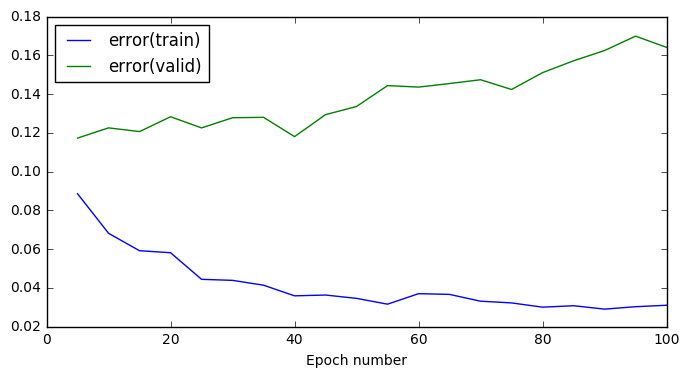

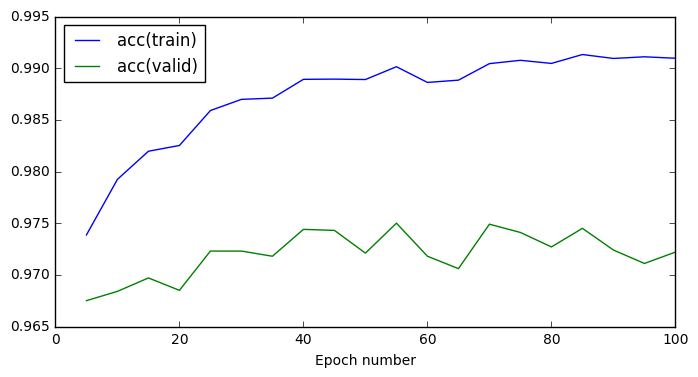

In [16]:
learningRate = 1e-3
beta = 0.9
learningRule = RmsPropLearningRule(learning_rate=learningRate, beta=beta)

numEpochs = 100

# Size of pools to take maximum over
pool_size = 2

# Probability of input being included in output in dropout layer
input_incl_prob = 0.9 #different for input layer
hidden_incl_prob = 0.7 #than the rest of the layers

#####################

# Create three affine layer model interleaved with max-pooling layers
model = MultipleLayerModel([
    #layer
    DropoutLayer(rng, input_incl_prob),
    AffineLayer(input_dim, hidden_dim * pool_size, weights_init, biases_init), 
    MaxPoolingLayer(pool_size),
        
    #layer
    DropoutLayer(rng, hidden_incl_prob),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

stats, keys, runTime = trainModel(model=model, error=error,learning_rule=learningRule, train_data=trainData,
                                   valid_data=validData,num_epochs = numEpochs, stats_interval=statsInterval,
                                   schedulers = [
        #ConstantLearningRateScheduler(learning_rate) #this actually does nothing so it's useless to include it
    ]
)

fig_1, ax_1, fig_2, ax_2 = plotStats(stats=stats, keys=keys, stats_interval=statsInterval)
figcount +=1
fig_1.savefig('experiment2_%02d_maxout_dropout_fig1.svg' % figcount)
fig_2.savefig('experiment2_%02d_maxout_dropout_fig2.svg' % figcount)

print "figcount: " + str(figcount)
print "runtime: " + str(runTime)

getFinalValues(stats)

We see here that regularization has been achieved again even with slightly larger inclusive probability for the hidden layer from 60% to 70% and even though the coefficient of the learning rate of the adaptive RMSprop learning rule was 10 times larger than the previous experiment.

Decreasing the maxout parameters made our experiment to run within ~15minutes and the final validation accuracy after 100 epochs was slightly higher than before.

## Annealed Dropout of starting Maxout and Dropout with RMSprop

### Starting input inclusive probability from 0.8 to 1
### Starting hidden layer inclusive probability from 0.1 to 1
### Percentage of epochs in the end where probability is equal to 100% constantly is 0.1
### Number of epochs: 200
### Max Pooling size 2

We see that the first run of the annealing dropout created a very smooth graph where the training curve was close to the validation/testing curve meaning that we have a good convergence.

In terms of performance this is not the best because we had to spend 100 epochs to achieve a not so bad accuracy but the whole training procedure took >15 minutes to complete

In terms of accuracy we did do better than our previous experiments at ~98.02% but not better than our top performance we saw

Epoch 0:
  error(train)=2.31e+00, acc(train)=9.63e-02, error(valid)=2.31e+00, acc(valid)=1.04e-01, params_penalty=0.00e+00
all probs from model: 0.8, 0.1
all probs from model: 0.801117318436, 0.105027932961
all probs from model: 0.802234636872, 0.110055865922
all probs from model: 0.803351955307, 0.115083798883
all probs from model: 0.804469273743, 0.120111731844
Epoch 5: 7.00s to complete
  error(train)=1.10e+00, acc(train)=7.20e-01, error(valid)=1.07e+00, acc(valid)=7.43e-01, params_penalty=0.00e+00
all probs from model: 0.805586592179, 0.125139664804
all probs from model: 0.806703910615, 0.130167597765
all probs from model: 0.80782122905, 0.135195530726
all probs from model: 0.808938547486, 0.140223463687
all probs from model: 0.810055865922, 0.145251396648
Epoch 10: 7.73s to complete
  error(train)=6.70e-01, acc(train)=8.09e-01, error(valid)=6.15e-01, acc(valid)=8.34e-01, params_penalty=0.00e+00
all probs from model: 0.811173184358, 0.150279329609
all probs from model: 0.8122905027

runtime: 1354.82056618


{'Final Testing Accuracy': 0.98029999999999862,
 'Final Testing Error': 0.09619017831096531,
 'Final Training Accuracy': 0.99876000000000054,
 'Final Training Error': 0.0061450748950512037}

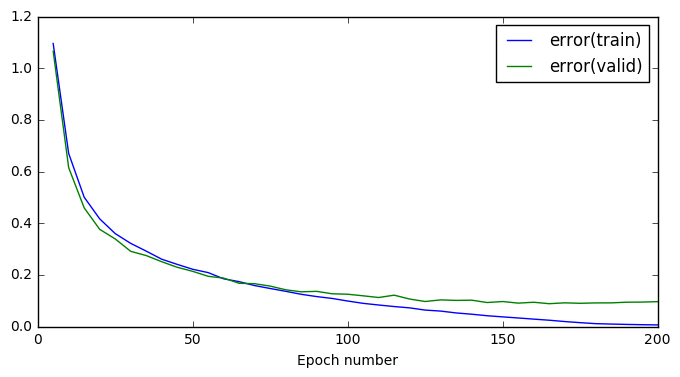

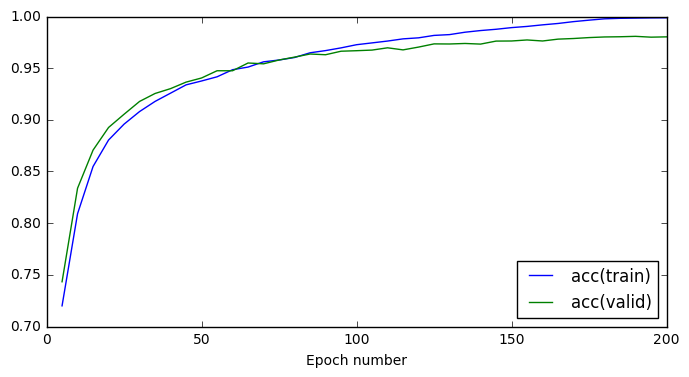

In [18]:
holdOnPercent = 0.1

learningRate = 1e-4
beta = 0.9
learningRule = RmsPropLearningRule(learning_rate=learningRate, beta=beta)

numEpochs = 200

# Size of pools to take maximum over
pool_size = 2

# Probability of input being included in output in dropout layer
startInputInclProb = 0.8 #different for input layer
startHiddenInclProb = 0.1 #than the rest of the layers

#####################

# Create three affine layer model interleaved with max-pooling layers
model = MultipleLayerModel([
    #
    DropoutLayer(rng, startInputInclProb),
    AffineLayer(input_dim, hidden_dim * pool_size, weights_init, biases_init), 
    MaxPoolingLayer(pool_size),
        
    #
    DropoutLayer(rng, startHiddenInclProb),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

stats, keys, runTime = trainModel(model=model, error=error,learning_rule=learningRule, train_data=trainData,
                                   valid_data=validData,num_epochs = numEpochs, stats_interval=statsInterval,
                                   schedulers = [
        AnnealedDropoutScheduler(model = model,
                         startInputInclProb = startInputInclProb,
                         startHiddenInclProb = startHiddenInclProb,
                         epochs = numEpochs,
                         holdOnPercent=holdOnPercent)
    ]
)

fig_1, ax_1, fig_2, ax_2 = plotStats(stats=stats, keys=keys, stats_interval=statsInterval)
figcount += 1
fig_1.savefig('experiment2_%02d_maxout_annealed_dropout_rmsProp_%.2f_%.2f_fig1.svg' % (figcount, startInputInclProb, startHiddenInclProb))
fig_2.savefig('experiment2_%02d_maxout_annealed_dropout_rmsProp_%.2f_%.2f_fig2.svg' % (figcount, startInputInclProb, startHiddenInclProb))

print "figcount: " + str(figcount)
print "runtime: " + str(runTime)

getFinalValues(stats)

Our second experiment where the epochs are 200 twice the number we had before it seems that when dropout inclusive probability increasing linearly it does not tend to increase the accuracy a lot. We had done worse in terms of performance.

However we have slightly increased the performance of the final accuracy for 0.1%.  
We have 98.1% of final performance accuracy.

By letting our model run for the last 10% of our test, for 20 epochs, with full probability it is obvious that the validation error starts to increase which means that we have overfitted since our dropout regularization is not active anymore and we do not have any other regularization in place.

### Starting input inclusive probability from 0.8 to 1
### Starting hidden layer inclusive probability from 0.1 to 1
### Percentage of epochs in the end where probability is equal to 1 constantly: 0.1
### Number of epochs 200
### Max Pooling size 4

Epoch 0:
  error(train)=1.63e+00, acc(train)=7.21e-02, error(valid)=2.31e+00, acc(valid)=9.85e-02, params_penalty=0.00e+00
all probs from model: 0.8, 0.1
all probs from model: 0.801117318436, 0.105027932961
all probs from model: 0.802234636872, 0.110055865922
all probs from model: 0.803351955307, 0.115083798883
all probs from model: 0.804469273743, 0.120111731844
Epoch 5: 12.19s to complete
  error(train)=1.10e+00, acc(train)=7.26e-01, error(valid)=1.07e+00, acc(valid)=7.53e-01, params_penalty=0.00e+00
all probs from model: 0.805586592179, 0.125139664804
all probs from model: 0.806703910615, 0.130167597765
all probs from model: 0.80782122905, 0.135195530726
all probs from model: 0.808938547486, 0.140223463687
all probs from model: 0.810055865922, 0.145251396648
Epoch 10: 13.29s to complete
  error(train)=6.28e-01, acc(train)=8.28e-01, error(valid)=5.83e-01, acc(valid)=8.50e-01, params_penalty=0.00e+00
all probs from model: 0.811173184358, 0.150279329609
all probs from model: 0.81229050

figcount: 7
runtime: 3312.20865393


{'Final Testing Accuracy': 0.9820999999999992,
 'Final Testing Error': 0.098154630284018191,
 'Final Training Accuracy': 0.99938000000000038,
 'Final Training Error': 0.0028349326601966609}

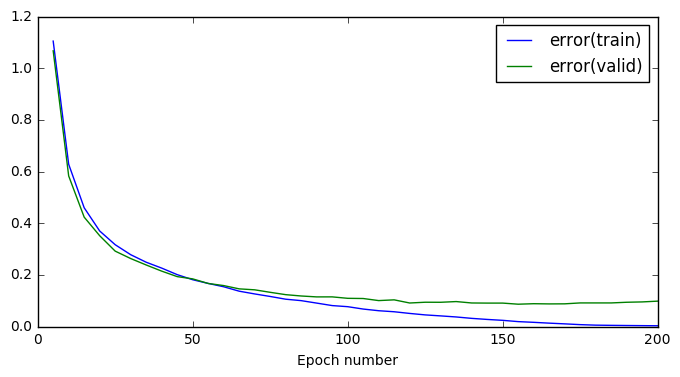

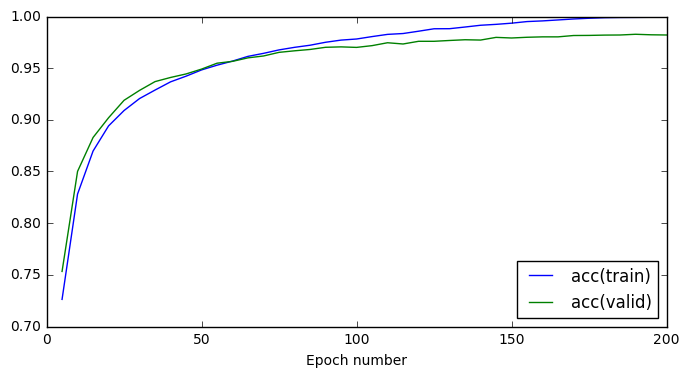

In [23]:
holdOnPercent = 0.1

learningRate = 1e-4
beta = 0.9
learningRule = RmsPropLearningRule(learning_rate=learningRate, beta=beta)

numEpochs = 200

# Size of pools to take maximum over
pool_size = 4

# Probability of input being included in output in dropout layer
startInputInclProb = 0.8 #different for input layer
startHiddenInclProb = 0.1 #than the rest of the layers

#####################

# Create three affine layer model interleaved with max-pooling layers
model = MultipleLayerModel([
    #
    DropoutLayer(rng, startInputInclProb),
    AffineLayer(input_dim, hidden_dim * pool_size, weights_init, biases_init), 
    MaxPoolingLayer(pool_size),
        
    #
    DropoutLayer(rng, startHiddenInclProb),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

stats, keys, runTime = trainModel(model=model, error=error,learning_rule=learningRule, train_data=trainData,
                                   valid_data=validData,num_epochs = numEpochs, stats_interval=statsInterval,
                                   schedulers = [
        AnnealedDropoutScheduler(model = model,
                         startInputInclProb = startInputInclProb,
                         startHiddenInclProb = startHiddenInclProb,
                         epochs = numEpochs,
                         holdOnPercent=holdOnPercent)
    ]
)

fig_1, ax_1, fig_2, ax_2 = plotStats(stats=stats, keys=keys, stats_interval=statsInterval)
figcount += 1
fig_1.savefig('experiment2_%02d_maxout_annealed_dropout_rmsProp_%.2f_%.2f_fig1.svg' % (figcount, startInputInclProb, startHiddenInclProb))
fig_2.savefig('experiment2_%02d_maxout_annealed_dropout_rmsProp_%.2f_%.2f_fig2.svg' % (figcount, startInputInclProb, startHiddenInclProb))

print "figcount: " + str(figcount)
print "runtime: " + str(runTime)

getFinalValues(stats)

And yes here annealing dropout resulted in one the highest validation accuracies we have seen. We must note that we donâ€™t expect annealing dropout to produce remarkable results in comparison to simple dropout nor that it is expected to yield a higher performance because it does nothing special in contributing to the architecture or the complexity or the simplicity of the model. However what annealing dropout does is maximize the potential of the model in hand by avoid the convergence towards local minima.

Because Annealing Dropout is just a computationally intensive procedure it worths doing some experiments with fewer number of epochs and different initial inclusive probabilities to see if we can get the same good results but faster.

### Starting input inclusive probability from 0.8 to 1
### Starting hidden layer inclusive probability from 0.5 to 1
### Percentage of epochs in the end where probability is equal to 1 constantly: 0.05
### Number of epochs 30
### Max Pooling size 4

Epoch 0:
  error(train)=2.35e+00, acc(train)=1.02e-01, error(valid)=2.34e+00, acc(valid)=1.01e-01, params_penalty=0.00e+00
all probs from model: 0.8, 0.5
all probs from model: 0.807407407407, 0.518518518519
all probs from model: 0.814814814815, 0.537037037037
all probs from model: 0.822222222222, 0.555555555556
all probs from model: 0.82962962963, 0.574074074074
Epoch 5: 10.78s to complete
  error(train)=2.37e-01, acc(train)=9.31e-01, error(valid)=2.23e-01, acc(valid)=9.39e-01, params_penalty=0.00e+00
all probs from model: 0.837037037037, 0.592592592593
all probs from model: 0.844444444444, 0.611111111111
all probs from model: 0.851851851852, 0.62962962963
all probs from model: 0.859259259259, 0.648148148148
all probs from model: 0.866666666667, 0.666666666667
Epoch 10: 12.33s to complete
  error(train)=1.47e-01, acc(train)=9.56e-01, error(valid)=1.46e-01, acc(valid)=9.58e-01, params_penalty=0.00e+00
all probs from model: 0.874074074074, 0.685185185185
all probs from model: 0.881481481

runtime: 395.63371706


{'Final Testing Accuracy': 0.97709999999999908,
 'Final Testing Error': 0.077706504433064316,
 'Final Training Accuracy': 0.99230000000000385,
 'Final Training Error': 0.029451786118968395}

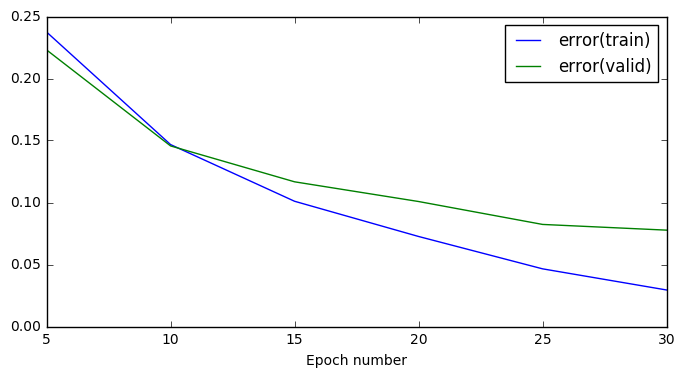

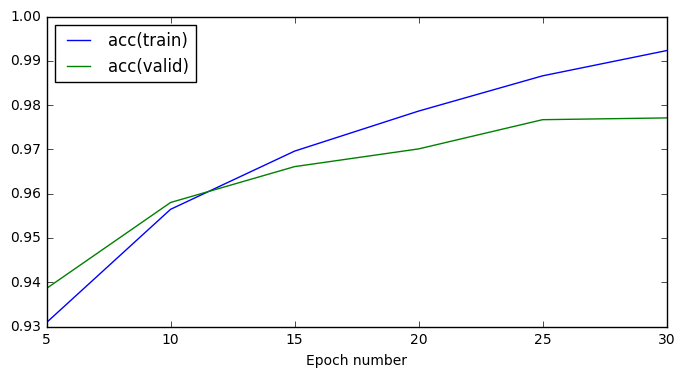

In [14]:
holdOnPercent = 0.05

learningRate = 1e-4
beta = 0.9
learningRule = RmsPropLearningRule(learning_rate=learningRate, beta=beta)

numEpochs = 30

# Size of pools to take maximum over
pool_size = 4

# Probability of input being included in output in dropout layer
startInputInclProb = 0.8 #different for input layer
startHiddenInclProb = 0.5 #than the rest of the layers

#####################

# Create three affine layer model interleaved with max-pooling layers
model = MultipleLayerModel([
    #
    DropoutLayer(rng, startInputInclProb),
    AffineLayer(input_dim, hidden_dim * pool_size, weights_init, biases_init), 
    MaxPoolingLayer(pool_size),
        
    #
    DropoutLayer(rng, startHiddenInclProb),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

stats, keys, runTime = trainModel(model=model, error=error,learning_rule=learningRule, train_data=trainData,
                                   valid_data=validData,num_epochs = numEpochs, stats_interval=statsInterval,
                                   schedulers = [
        AnnealedDropoutScheduler(model = model,
                         startInputInclProb = startInputInclProb,
                         startHiddenInclProb = startHiddenInclProb,
                         epochs = numEpochs,
                         holdOnPercent=holdOnPercent)
    ]
)

fig_1, ax_1, fig_2, ax_2 = plotStats(stats=stats, keys=keys, stats_interval=statsInterval)
figcount += 1
fig_1.savefig('experiment2_%02d_maxout_annealed_dropout_rmsProp_%.2f_%.2f_fig1.svg' % (figcount, startInputInclProb, startHiddenInclProb))
fig_2.savefig('experiment2_%02d_maxout_annealed_dropout_rmsProp_%.2f_%.2f_fig2.svg' % (figcount, startInputInclProb, startHiddenInclProb))

print "figcount: " + str(figcount)
print "runtime: " + str(runTime)

getFinalValues(stats)

This experiment did not yield the expected results. Seems like 30 epochs is not slow enough for the model to go from simpler to more complex representations

### Starting input inclusive probability from 0.8 to 1
### Starting hidden layer inclusive probability from 0.1 to 1
### Percentage of epochs in the end where probability is equal to 1 constantly: 0.05
### Number of epochs 50
### Max Pooling size 4

Epoch 0:
  error(train)=2.32e+00, acc(train)=1.00e-01, error(valid)=2.32e+00, acc(valid)=1.04e-01, params_penalty=0.00e+00
all probs from model: 0.8, 0.1
all probs from model: 0.804347826087, 0.119565217391
all probs from model: 0.808695652174, 0.139130434783
all probs from model: 0.813043478261, 0.158695652174
all probs from model: 0.817391304348, 0.178260869565
Epoch 5: 11.49s to complete
  error(train)=7.77e-01, acc(train)=7.99e-01, error(valid)=7.32e-01, acc(valid)=8.20e-01, params_penalty=0.00e+00
all probs from model: 0.821739130435, 0.197826086957
all probs from model: 0.826086956522, 0.217391304348
all probs from model: 0.830434782609, 0.236956521739
all probs from model: 0.834782608696, 0.25652173913
all probs from model: 0.839130434783, 0.276086956522
Epoch 10: 16.23s to complete
  error(train)=3.74e-01, acc(train)=8.92e-01, error(valid)=3.35e-01, acc(valid)=9.04e-01, params_penalty=0.00e+00
all probs from model: 0.84347826087, 0.295652173913
all probs from model: 0.847826086

runtime: 821.790541172


{'Final Testing Accuracy': 0.97949999999999904,
 'Final Testing Error': 0.081238606177604145,
 'Final Training Accuracy': 0.99300000000000366,
 'Final Training Error': 0.027229031752991996}

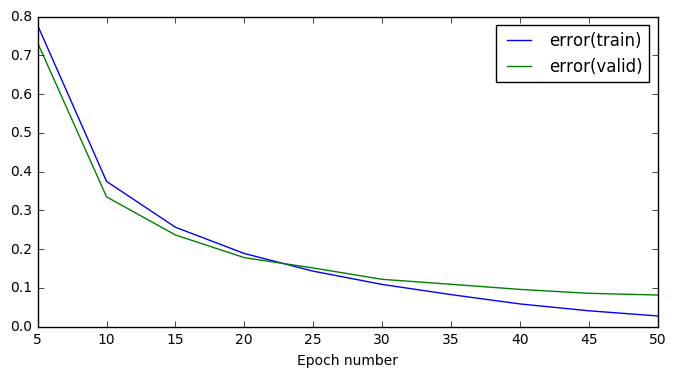

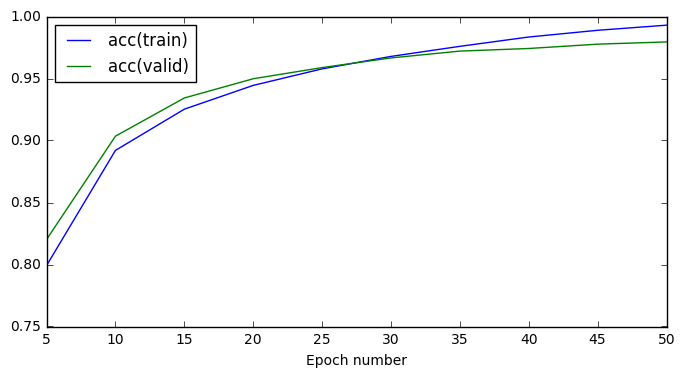

In [15]:
holdOnPercent = 0.05

learningRate = 1e-4
beta = 0.9
learningRule = RmsPropLearningRule(learning_rate=learningRate, beta=beta)

numEpochs = 50

# Size of pools to take maximum over
pool_size = 4

# Probability of input being included in output in dropout layer
startInputInclProb = 0.8 #different for input layer
startHiddenInclProb = 0.1 #than the rest of the layers

#####################

# Create three affine layer model interleaved with max-pooling layers
model = MultipleLayerModel([
    #
    DropoutLayer(rng, startInputInclProb),
    AffineLayer(input_dim, hidden_dim * pool_size, weights_init, biases_init), 
    MaxPoolingLayer(pool_size),
        
    #
    DropoutLayer(rng, startHiddenInclProb),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

stats, keys, runTime = trainModel(model=model, error=error,learning_rule=learningRule, train_data=trainData,
                                   valid_data=validData,num_epochs = numEpochs, stats_interval=statsInterval,
                                   schedulers = [
        AnnealedDropoutScheduler(model = model,
                         startInputInclProb = startInputInclProb,
                         startHiddenInclProb = startHiddenInclProb,
                         epochs = numEpochs,
                         holdOnPercent=holdOnPercent)
    ]
)

fig_1, ax_1, fig_2, ax_2 = plotStats(stats=stats, keys=keys, stats_interval=statsInterval)
figcount += 1
fig_1.savefig('experiment2_%02d_maxout_annealed_dropout_rmsProp_%.2f_%.2f_fig1.svg' % (figcount, startInputInclProb, startHiddenInclProb))
fig_2.savefig('experiment2_%02d_maxout_annealed_dropout_rmsProp_%.2f_%.2f_fig2.svg' % (figcount startInputInclProb, startHiddenInclProb))

print "figcount: " + str(figcount)
print "runtime: " + str(runTime)

getFinalValues(stats)

Here we have not achieved any remarkable results in comparison to previous experiments but it is interesting to note that with 20 more epochs we were able to derive a better final model with higher validation accuracy than before. Note that here we have started from 0.1 initial inclusive probability for the hidden layers but this did not have any slowing-down or other unwanted effect.  
This experiment is a good indication that we should better start from lower probabilities rather than higher ones for the hidden layer.